<a href="https://colab.research.google.com/github/jhejna/rlworkshop/blob/main/MB_RL_Workshop_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

In [ ]:
%%bash
# install required system dependencies
apt-get install -y xvfb x11-utils
# install required python dependencies (might need to install additional gym extras depending)
pip install gym pyvirtualdisplay

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,977 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.7 [783 kB]
Fetched 993 kB in 1s (1,209 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
S

In [ ]:
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False, size=(640, 480))
_ = _display.start()

In [ ]:
!echo $DISPLAY

:0


Episodes: 4


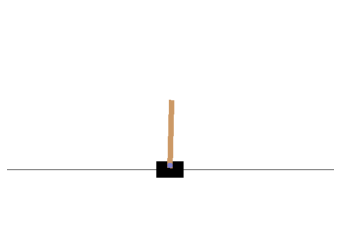

In [ ]:
# Test rendering a gym environment
import gym
import matplotlib.pyplot as plt
from IPython import display

env = gym.make('CartPole-v1')
num_ep = 0
obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for _ in range(100):
    ac = env.action_space.sample()
    obs, reward, done, info = env.step(ac)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done:
        obs = env.reset()
        num_ep += 1
env.close()
del env
del img
print("Episodes:", num_ep)

# 1. PETS
For this workshop we will implement the Probablistic Ensembles with Trajectory Sampling (PETS) algorithm from "Deep Reinforcement Learning in a Handful of Trials Using Probabilistic Models"

Here is a link to the paper: https://arxiv.org/abs/1805.12114

The basic idea is this: learned dynamics models often accumulate a large amount of error that leads to bad plans. By planning through an ensemble, or collection of models, we can mitigate this error.

Similar to the last workshop, we will work with the simple discrete cartpole environment.


In [ ]:
# Import the required modules
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import gym

## a) Dynamics Models
PETS uses an ensemble of probablistic models. What does this mean?
1. Rather than just predicting the next state, we predict a distribution over the possible next states. In the authors implementation, this takes the form of a diagonal multivariate gaussian distribution.
2. Rather than having a single dynamics model and sampling from it during planning, we use an ensemble to reduce error.

In this section, you will implement both a guassian dynamics model in the form of an MLP and an ensemble wrapper.

Here are a few things to remember when making the dynamics model:
1. The dynamics model takes in the state and action and predicts the next state. 
2. For the guassian model, we need to predict a mean and variance for each component of the state.
3. Dynamics models generally perform better when they predict the delta to the next state. For example `next_state = prediction + state` 

In [ ]:
class GaussMLP(nn.Module):

    def __init__(self, in_dim, out_dim, hidden_dims=[256, 256]):
        super().__init__()
        layers = []
        last_layer_dim = in_dim
        for layer in hidden_dims:
            layers.append(nn.Linear(last_layer_dim, layer))
            last_layer_dim = layer
        self.extractor_layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(last_layer_dim, out_dim*2)

        self.max_logvar = nn.Parameter(torch.ones(1, out_dim, dtype=torch.float32) / 2.0)
        self.min_logvar = nn.Parameter(- torch.ones(1, out_dim, dtype=torch.float32) * 10.0)

    def forward(self, x):
        for layer in self.extractor_layers:
            x = layer(x)
            x = x * torch.sigmoid(x)
        mu, logvar = torch.chunk(self.output_layer(x), 2, dim=1)
        # Note, authors use softplus here and bound it.
        logvar = self.max_logvar - F.softplus(self.max_logvar - logvar)
        logvar = self.min_logvar + F.softplus(logvar - self.min_logvar)
        return mu, logvar
    
class GaussEnsemble(nn.Module):

    def __init__(self, in_dim, out_dim, ensemble_size, hidden_dims=[256, 256]):

        self.models = nn.ModuleList([GaussMLP(in_dim, out_dim, hidden_dims=hidden_dims) for _ in range(ensemble_size)])

    def forward(self, x):
        means, logvars = [], []
        for model in self.models:
            mean, logvar = model(x)
            means.append(mean)
            logvars.append(logvar)
        return means, logvars

    

## b) Environment Setup
In model based reinforcement learning, we plan using the reward function. For example, in random shooting, trajectory optimization we will later implement, you rank different action sequences by the sum of their rewards. This means that we will need access to the reward function. By default, this isnt provided in gym, so I have provided it here.

In [ ]:
def reward_function(state):
    x = state[:, 0]
    theta = state[:, 2]
    theta_thres = 12 * 2 * math.pi / 360

    x_done = np.logical_or(x < -2.4, x > 2.4)
    theta_done = np.logical_or(theta < -theta_thres, theta > theta_thres)

    done = np.logical_or(x_done, theta_done)
    return 1 - done

Next, we need to collect data from the environment. In model based RL it's nice to package this in a single function instead of having it in your training loop. We haven't talked about how you actually plan in the environment yet, so we'll assume that you have some `act_fn` that when provided an observation will predict the next action you take. For example `action = act_fn(observation)`

The `collect_data` function will take in an environment, an `act_fn`, and a number of `timesteps`, and use the `act_fn` to collect data for the specified number of timesteps. 

You should be able to figure out how to do this from the model free RL workshop training loop or testing functions. It's nice to log values here so you can see how your policy does.

In [ ]:
def collect_data(env, act_fn, timesteps):
    inputs = np.zeros((timesteps, 6))
    targets = np.zeros((timesteps, 4))

    obs = env.reset()
    ep_rewards = []
    ep_reward = 0
    for i in range(timesteps):
        pred_ac = act_fn(obs)
        next_obs, reward, done, _ = env.step(pred_ac)
        ac = np.zeros(2)
        ac[pred_ac] = 1
        inputs[i] = np.concatenate((obs, ac))
        targets[i] = next_obs
        ep_reward += reward
        if done:
            print("Episode Reward", ep_reward)
            ep_rewards.append(ep_reward)
            ep_reward = 0
            obs = env.reset()
        else:
            obs = next_obs
    if len(ep_rewards) == 0:
        print("Total Ep Reward", ep_reward)
    else:
        print("Last Ep Reward", ep_rewards[-1])
    return inputs, targets

## c) MPC Planning with Random Shooting
MPC, or model predictive control, is a way of using dynamics models and a reward function to predict the action that should be taken in an environment. We will implement random shooting in particular.

In random shooting, a number of random trajectories are sampled. Each trajectory is then assigned a total reward using the reward function. Finally, the tracjectory with the highest reward is selected and the first action is used.

Alone, random shooting, well sucks. PETS utilizes the ensemble of probablistic models to make it not so bad. In the paper, they use a more complicated algorithm called the cross entropy method that we will not get into here :).

In this section, implement random shooting for PETS. This will require the following modifications in addition to regular random shooting:
1. Randomly sampling next states using the probablity distribution output by a given model.
2. Compute rewards for each trajectory under all of the different models. Average the final reward across all dynamics models in the ensemble to get a better estimate.

Keep in mind that the slowest part of training our model is now planning. It's crucial that your implementation of random shooting predicts next states for all samples in parallel (ie one large batch). Otherwise, you will be waiting years for everything to finish.

Warning: this is by far the hardest part of the PETS algorithm :)

In [ ]:
def act(obs, models, reward_fn, horizon):
    # Generate plans of length "Horizon"
    # Each model predicts a cost over acting for horizon timesteps.
    possibilities = np.eye(2)
    num_samples = 100
    solutions = np.eye(2)[np.random.choice(2, num_samples*horizon)].reshape((num_samples, horizon, 2))
    obs = torch.from_numpy(np.tile(obs, (num_samples, len(models), 1))).float()
    rewards = np.zeros((num_samples, len(models)))
    for i in range(horizon):
        # Construct input for the models.
        ac = torch.from_numpy(np.tile(solutions[:, i:i+1, :], (1, len(models), 1))).float()
        inputs = torch.cat((obs, ac), dim=-1)
        with torch.no_grad():
            for j, model in enumerate(models):
                mean, logvar = model(inputs[:, j, :])
                prediction = mean + torch.randn_like(mean) * torch.exp(logvar).sqrt()
                prediction = prediction + obs[:, j, :]
                rewards[:, j] += reward_fn(prediction).cpu().numpy()
                obs[:, j, :] = prediction
    # Compute average returns of the trajectories
    avg_returns = np.mean(rewards, axis=1)
    best_traj = np.argmax(avg_returns)
    best_ac = np.argmax(solutions[best_traj, 0, :])
    return best_ac

## d) Training Loop
Implement the training loop for the algorithm. This should be done in two phases:
1. Collect data
2. Train the models

Usually, models are initiallized using a few random episodes and warmed up before trying to plan.

Look at the PETS paper to determine what the loss should be. Hint: It should have something for both the mean and variance. Its fine if the loss becomes negative due to the variance term.

In [ ]:
import math

env = gym.make("CartPole-v1")
# State Dim is 2, action is one hot of size 2
batch_size = 64
epochs = 2
iterations = 15
timesteps = 400
horizon = 10

models = [GaussMLP(4+2, 4) for i in range(5)]
parameters = []
for model in models:
    parameters.extend(model.parameters())
optim = torch.optim.Adam(parameters, lr=0.001)

# Collect initial data and train.
inputs, targets = collect_data(env, lambda x: env.action_space.sample(), timesteps)

for i in range(iterations):
    
    for _ in range(epochs):
        perm = np.random.permutation(len(inputs))
        num_full_batches = len(perm) // batch_size
        for i in range(num_full_batches + 1):
            if i != num_full_batches:
                inds = perm[i*batch_size:(i+1)*batch_size]
            else:
                inds = perm[i*batch_size:]
            x = torch.from_numpy(inputs[inds]).float()
            y = torch.from_numpy(targets[inds]).float()

            loss = 0.0
            for model in models:
                mean, logvar = model(x)
                loss += torch.mean(((mean - y)**2) * torch.exp(-logvar) + logvar)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
        print("Loss", loss.item())
    # Collect new data
    new_inputs, new_targets = collect_data(env, lambda obs: act(obs, models, reward_function, horizon), timesteps)
    inputs = np.concatenate((inputs, new_inputs), axis=0)
    targets = np.concatenate((targets, new_targets), axis=0)

Episode Reward 16.0
Episode Reward 18.0
Episode Reward 38.0
Episode Reward 87.0
Episode Reward 29.0
Episode Reward 30.0
Episode Reward 19.0
Episode Reward 12.0
Episode Reward 15.0
Episode Reward 15.0
Episode Reward 34.0
Episode Reward 37.0
Episode Reward 11.0
Episode Reward 14.0
Episode Reward 16.0
Last Ep Reward 16.0
Loss -2.508418560028076
Loss -4.8170390129089355
Episode Reward 17.0
Episode Reward 38.0
Episode Reward 12.0
Episode Reward 24.0
Episode Reward 19.0
Episode Reward 69.0
Episode Reward 17.0
Episode Reward 57.0
Episode Reward 20.0
Episode Reward 19.0
Episode Reward 77.0
Last Ep Reward 77.0
Loss -14.063005447387695
Loss -22.614952087402344
Episode Reward 180.0
Episode Reward 215.0
Last Ep Reward 215.0
Loss -26.553691864013672
Loss -23.265932083129883
Episode Reward 370.0
Last Ep Reward 370.0
Loss nan
Loss nan
Episode Reward 268.0
Last Ep Reward 268.0
Loss -29.22855567932129
Loss -35.8186149597168
Episode Reward 247.0
Last Ep Reward 247.0
Loss -37.23290252685547
Loss -35.8180

KeyboardInterrupt: ignored

## e) Tuning
Play with the hyper-parameters and see how high you can get the reward!

Model based RL is _even_ more unstable than model free RL :). Good luck!

Within a around 75 episodes I was able to get a reward of over 350, though my implementation was pretty unstable and tended to crash :P. This is the problem with using random shooting! My loss nanned a few times, this can be fixed by better controlling the variance term of the loss.

# 2. VAEs and World Models

In this section you'll implement a very simple VAE that could be used in some type of world model for MB RL from images. Though typically you would do this by collecting data from environments, we will do this on the MNIST dataset for simplicity.

Here is the link to the original VAE Paper:
https://arxiv.org/pdf/1312.6114.pdf

And the world models paper: https://arxiv.org/abs/1803.10122


## a) Data Collection

Note sometimes this tends to error because of the display environment being buggy in colab. If it crashes, go ahead and re-run the set display block at the top of the noteobok.

In [ ]:
import gym
import numpy as np
from PIL import Image, ImageOps

env = gym.make('CartPole-v1')
data = []
data_size = 2000

obs = env.reset()
ac = 0
for _ in range(data_size):
    if np.random.rand() < 0.5:
        ac = env.action_space.sample()
    obs, reward, done, info = env.step(ac)
    img = Image.fromarray(env.render(mode='rgb_array'))
    img_gray = ImageOps.grayscale(img)
    img_resize = img_gray.resize((56,56))
    img_crop = img_resize.crop((8,8, 48, 48))
    data.append(np.array(img_crop))
    if done:
        obs = env.reset()
env.close()
del env
del img


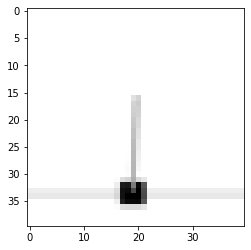

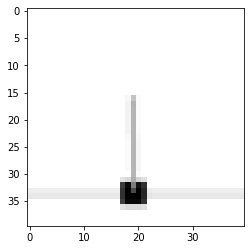

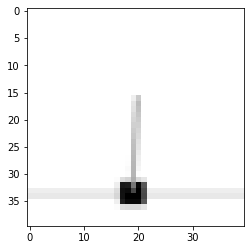

In [ ]:
# Now Shuffle the data, and visualize some images
data = np.array(data)
np.random.shuffle(data)

# Visualize some random images
from matplotlib import pyplot as plt
plt.imshow(data[0], cmap='gray')
plt.show()
plt.imshow(data[1], cmap='gray')
plt.show()
plt.imshow(data[2], cmap='gray')
plt.show()

In [ ]:
# Normalize data between -1 and 1
data = data / 255.0 # Between zero and one
data *= 2 # Between zero and two
data -= 1 # Between -1 and 1

# Expand dims of data and reorder in order to fit pytorch image conventions N x C x W x H
data = np.expand_dims(data, 1)
print("Data Shape", data.shape)

np.save('data.npy', data)

# Test loading the data
data = np.load('data.npy')

Data Shape (2000, 1, 40, 40)


## b) Model Architectures

Next, you need to define a simple convolutional architecture for the encoder and decoder. Here are things to consider:

1. Choose an appropriate size for the latent z
2. Remember that the encoder must predict both a mean and standard deviation.
3. The standard deviation (or variance) must be a positive quantity!
4. The encoder and decoder architectures should closely mirror eachother.


In [ ]:
import torch
import numpy as np
from torch import nn

class Encoder(nn.Module):

    def __init__(self, input_channels, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.extractor = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 2*latent_dim)
        )

    def forward(self, x):
        x = self.extractor(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        return mu, logvar

class Decoder(nn.Module):

    def __init__(self, output_channels, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.linear = nn.Linear(latent_dim, 1024)
        self.extractor = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, output_channels, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.Tanh(), # Add Tanh activation at end to bond inputs / outputs
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(-1, 64, 4, 4)
        x = self.extractor(x)
        return x

class VAE(nn.Module):

    def __init__(self, channels, latent_dim):
        super().__init__()
        self.encoder = Encoder(channels, latent_dim)
        self.decoder = Decoder(channels, latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        eps = torch.randn_like(mu)
        z = mu + eps*torch.exp(0.5*logvar)
        # Now feed z through the decoder
        x_hat = self.decoder(z)
        assert x_hat.shape == x.shape

        # Compute the KLD and the MSE
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        SE = torch.sum((x - x_hat)**2, dim=(1,2,3))
        MSE = torch.mean(SE)

        loss = MSE + KLD
        return loss

## c) Training Loop
Now we code the training loop. We can do this really easily with pytorch data loaders!

In [ ]:
batch_size = 128
lr = 1e-3
latent_dim = 16
epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# create data loader
data = np.load('data.npy')
trainloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

model = VAE(1, latent_dim)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    for batch in trainloader:
        batch = batch.to(device).float()
        optimizer.zero_grad()
        loss = model(batch)
        loss.backward()
        optimizer.step()

    print("Finished epoch", epoch, "loss", loss.item())

# Now let's generate some samples

Finished epoch 0 loss 1058.80712890625
Finished epoch 1 loss 299.910400390625
Finished epoch 2 loss 186.0967559814453
Finished epoch 3 loss 166.36074829101562
Finished epoch 4 loss 158.68284606933594
Finished epoch 5 loss 155.00149536132812
Finished epoch 6 loss 153.71517944335938
Finished epoch 7 loss 152.3987274169922
Finished epoch 8 loss 150.95350646972656
Finished epoch 9 loss 150.010498046875
Finished epoch 10 loss 149.40382385253906
Finished epoch 11 loss 148.57235717773438
Finished epoch 12 loss 147.79588317871094
Finished epoch 13 loss 147.5283660888672
Finished epoch 14 loss 146.49386596679688
Finished epoch 15 loss 145.9591522216797
Finished epoch 16 loss 145.48780822753906
Finished epoch 17 loss 145.2503204345703
Finished epoch 18 loss 144.4003143310547
Finished epoch 19 loss 143.68055725097656
Finished epoch 20 loss 142.87315368652344
Finished epoch 21 loss 142.33673095703125
Finished epoch 22 loss 141.77294921875
Finished epoch 23 loss 140.870849609375
Finished epoch 24 l

## d) Evaluation

Now assess the quality of the learned model by sampling from the latent (sampling z, then examining x_hat)

Note that an easy way of displaying the images is torchvision makegrid, it does a lot of the deprocessing work for you! 


It won't be super good, but you should be able to see the base of the cart! If you mess with the architecture I'm sure you can get it to peform better!

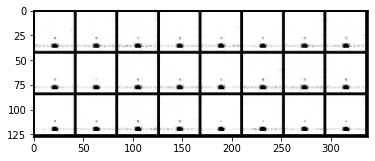

In [ ]:
import torchvision
from matplotlib import pyplot as plt
from PIL import Image

# Samples!
num_samples = 24
samples = model.decoder(torch.randn(num_samples, latent_dim).to(device)).detach().cpu()
sample_grid = torchvision.utils.make_grid(samples)
sample_img = torchvision.utils.save_image(sample_grid, 'samples.png')
plt.imshow(Image.open('samples.png'))
plt.show()
